#  Rulefit Boston Housing Demo

Rulefit algorithm aims for a compromise between interpretability and complexity of the resulting model. While simpler ML algorithms usually miss interaction effects or require advanced methods to uncover interaction effects, rulefit learns a sparse linear model that include automatically detected interaction effects in the form of decision rules. After that, new features are created in the form of decision rules and a transparent model is built using these features.

Example: IF the number of rooms > 2 AND the age of the house < 15 THEN 1 ELSE 0 (lower than medium)

The general algorithm flow:

1. Algorithm fits a tree ensemble to the data, builds a rule ensemble by traversing each tree. This results in many rules but majority of them not informative.
2. After that, it evaluates the rules on the data to build a rule feature set and fits a sparse linear model (LASSO) to the rule feature set joined with the original feature set, to select the best ones. 

### Boston house prices dataset:

The response variable is the price of the houses and the goal is to produce a model with significant variables that can predict the house price using the given explanatory variables. Each record describes a Boston suburb or town. The data was created from the Boston Standard Metropolitan Statistical Area (SMSA) in the 70s. The attributes are defined as follows:

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25000 sq. ft.
- INDUS: proportion of non retail business acres per town
- CHAS: Charles River dummy var (= 1 if tract bounds rivers; 0 othervise)
- NOX: nitric oxides concentration (parts per 10 milion)
- RM: average number of rooms per dweling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighed distances to five Boston employment centers
- RAD: index of accesibility to radial highways
- TAX: full value property=tax rate per 10000 USD
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes in 1000s USD

In [288]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,16 secs
H2O_cluster_timezone:,Europe/Bratislava
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 50 minutes
H2O_cluster_name:,zuzanaolajcova
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.547 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [289]:
train = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv")
x = train.columns
y = "medv"
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


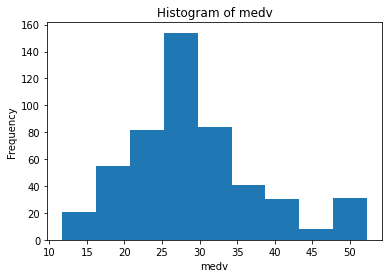

breaks,counts,mids_true,mids,widths
9.5,nan,nan,nan,nan
14,21,2.5,11.75,4.5
18.5,55,4.75,16.25,4.5
23,82,7,20.75,4.5
27.5,154,9.25,25.25,4.5
32,84,11.5,29.75,4.5
36.5,41,13.75,34.25,4.5
41,30,16,38.75,4.5
45.5,8,18.25,43.25,4.5
50,31,20.65,47.75,4.5


In [290]:
train['medv'].hist()

In [291]:
train.head()

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
0.21124,12.5,7.87,0,0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5
0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9


Before training a rulefit model, we will train a tree based model for comparison. By default, rulefit uses H2ORandomForestEstimator in the following configuration:

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RMSE: 
4.317174102250105


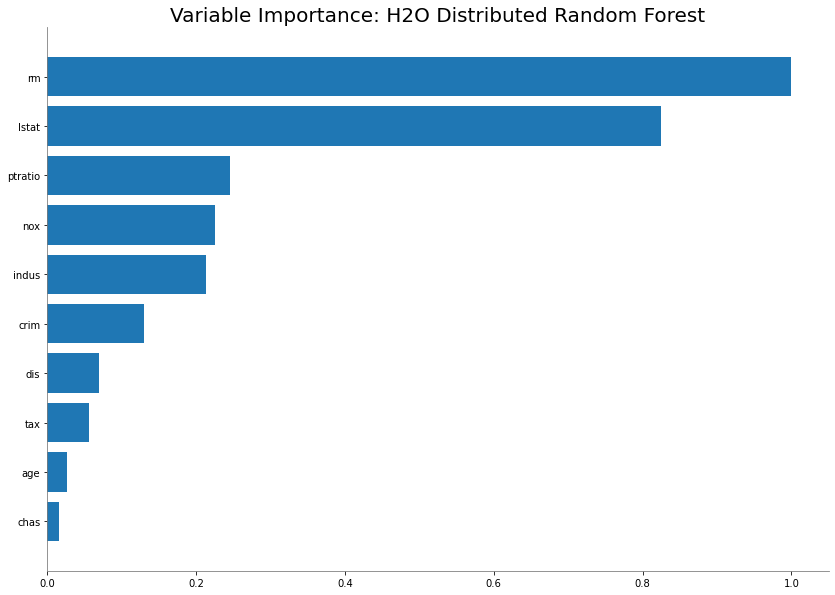

<Figure size 432x288 with 0 Axes>

In [292]:
drf = H2ORandomForestEstimator(ntrees=50, seed=123, max_depth=3)
drf.train(y=y,training_frame=train)
print("RMSE: ")
print(drf.training_model_metrics()['RMSE'])
drf.varimp_plot()

As we can see, RM and LSTAT are the most significant features affecting the house price. 
Now, let's create a rulefit model to a create custom rules for more explainability and interpretability:

In [278]:
    from h2o.estimators.rulefit import H2ORuleFitEstimator
    rf = H2ORuleFitEstimator(seed=123, lambda_=.5 )#,  model_type="rules")
    rf.train(y=y, training_frame=train)
    print("RMSE: ")
    print(rf.training_model_metrics()['RMSE'])
    rf.rule_importance()

rulefit Model Build progress: |██████████████████████████████████████████████████| (done) 100%
RMSE: 
4.731860083006494

Rule Importance: 


,,variable,coefficient,support,rule
0,,linear.rm,3.326399,1.000000,
1,,M0T6N17,2.722437,0.130435,(age < 97.798828125 or age is NA) & (ptratio < 19.695898056030273 ...
2,,linear.chas,1.630986,1.000000,
3,,M0T3N15,1.113996,0.077075,(dis < 5.962222099304199 or dis is NA) & (lstat < 4.830895900726318)
4,,linear.ptratio,-0.618241,1.000000,
5,,linear.lstat,-0.507623,1.000000,
6,,M0T33N21,-0.231355,0.258893,(dis >= 1.3014265298843384 or dis is NA) & (rm >= 5.569091796875 o...
7,,linear.dis,-0.056060,1.000000,
8,,linear.crim,-0.018163,1.000000,
9,,linear.b,0.005108,1.000000,


Rulefits's rule importance table shows all the predictors with non-zero LASSO coefficients. Predictors can be linear (variable name prefixed with "linear.") or a rule (rule identificator as a variable name, e.g. M0T43N16 means this rule comes from the tree based model n.0, tree n.43, node n.16). This table holds values of LASSO coefficient and support of undrlying predictor as a factors of predictor importances. In case of rule predictor, also it's language representation is present.

Let's look closer on resulting predictors. From the table we can see that the rules selected by rulefit as most important have LSTAT, RM or PTRATIO variables present. Those which were also the top 3 most important variables of previous H2ORandomForestEstimator model.

Let's try to interpret significant rules:

The full text of M0T6N17 is:

In [279]:
rf.rule_importance()[4][1]

'(age < 97.798828125 or age is NA) & (ptratio < 19.695898056030273 or ptratio is NA) & (rm >= 6.940098762512207)'

Which means that the most expensive houses have 7 or more rooms, are in towns/suburbs with possibly above-average pupil-teacher ratio and are in areas with possibly high proportion of historical buildings.

The full text of M0T3N15 is:

In [280]:
rf.rule_importance()[4][3]

'(dis < 5.962222099304199 or dis is NA) & (lstat < 4.830895900726318)'

Which means that areas with very-low-to-zero percentage of lower status of the population and average-to-zero weighed distances to five Boston employment centers are more expensive to live in.

The full text of M0T33N21 is:

In [281]:
rf.rule_importance()[4][6]

'(dis >= 1.3014265298843384 or dis is NA) & (rm >= 5.569091796875 or rm is NA) & (tax >= 416.5)'

Which can be interpreted as: "with increasing distance from Boston employment centers and increasing, above average tax rates and more than 5 rooms, the price of house degrades".

We can also find out at which specific rows the certain rules apply or not:

In [282]:
predicted_rules = rf.predict_rules(train, ["M0T6N17", "M0T33N21", "linear.rm"])
predicted_rules.head()

M0T6N17,M0T33N21,linear.rm
0,0,1
0,0,1
1,0,1
1,0,1
1,0,1
0,0,1
0,0,1
0,0,1
0,0,1
0,0,1


Please note, that linear predictor applies to all the observations and that col-wise sums of this output divided by the number of observations represents a support of each rule.

Apart of that, Friedman and Popescu defines (https://arxiv.org/abs/0811.1679) the rulefit-specific global measure of predictors importance as follows:

In [283]:
def FPimportance(data, lasso_coef, support, is_rule):
    if is_rule:
        import math
        return abs(lasso_coef) * math.sqrt(support * (1 - support))
    else:
        return abs(lasso_coef) * data.sd()[0]

Hence, we can get global importances calculated out of combined importance factors like:

In [284]:
def calculate_FPimportance(input, data):
    result = dict()
    for x in range(len(input[1])):
        if input[1][x].startswith('linear.'):
            result[input[1][x]] = FPimportance(data[input[1][x][len("linear."):]], input[2][x], input[3][x], False)
        else:
            result[input[1][x]] = FPimportance(None, input[2][x], input[3][x], True)
    return result  

In [285]:
FPimportances = calculate_FPimportance(rf.rule_importance(), train)

In [286]:
import operator
sorted_FPimportances = sorted(FPimportances.items(), key=operator.itemgetter(1), reverse=True)

Which gives us a slightly reordered list of importances:

In [287]:
sorted_FPimportances

[('linear.lstat', 3.6249636445204896),
 ('linear.rm', 2.337185286818319),
 ('linear.ptratio', 1.3384578280449766),
 ('M0T6N17', 0.9168655046932702),
 ('linear.b', 0.46635150056661134),
 ('linear.chas', 0.4142606755107032),
 ('M0T3N15', 0.29711442203128424),
 ('linear.crim', 0.15622850181241044),
 ('linear.dis', 0.11804690411237816),
 ('M0T33N21', 0.10133965829049822)]

Stay tuned for the future improvements, mainly rulefit-specific tools for importance and interaction examination!